In [1]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 300
lr = 0.001
num_outputs = 10
seq_len = 200
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2118410


In [3]:
%matplotlib inline
model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\check_point_0.pt", weights_only=True))
model.eval() 
print("")

In [18]:
# %matplotlib inline
# plt.scatter(np.arange(num_epochs), trains, label="training loss")
# plt.show()

In [25]:
%matplotlib inline
temp_batch_size = 9
train_X, train_Y, true_X,true_Y, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=8, random_seed=202020220)
model.eval()
batch_classes = batch_classes.permute(1,0)
print("") 


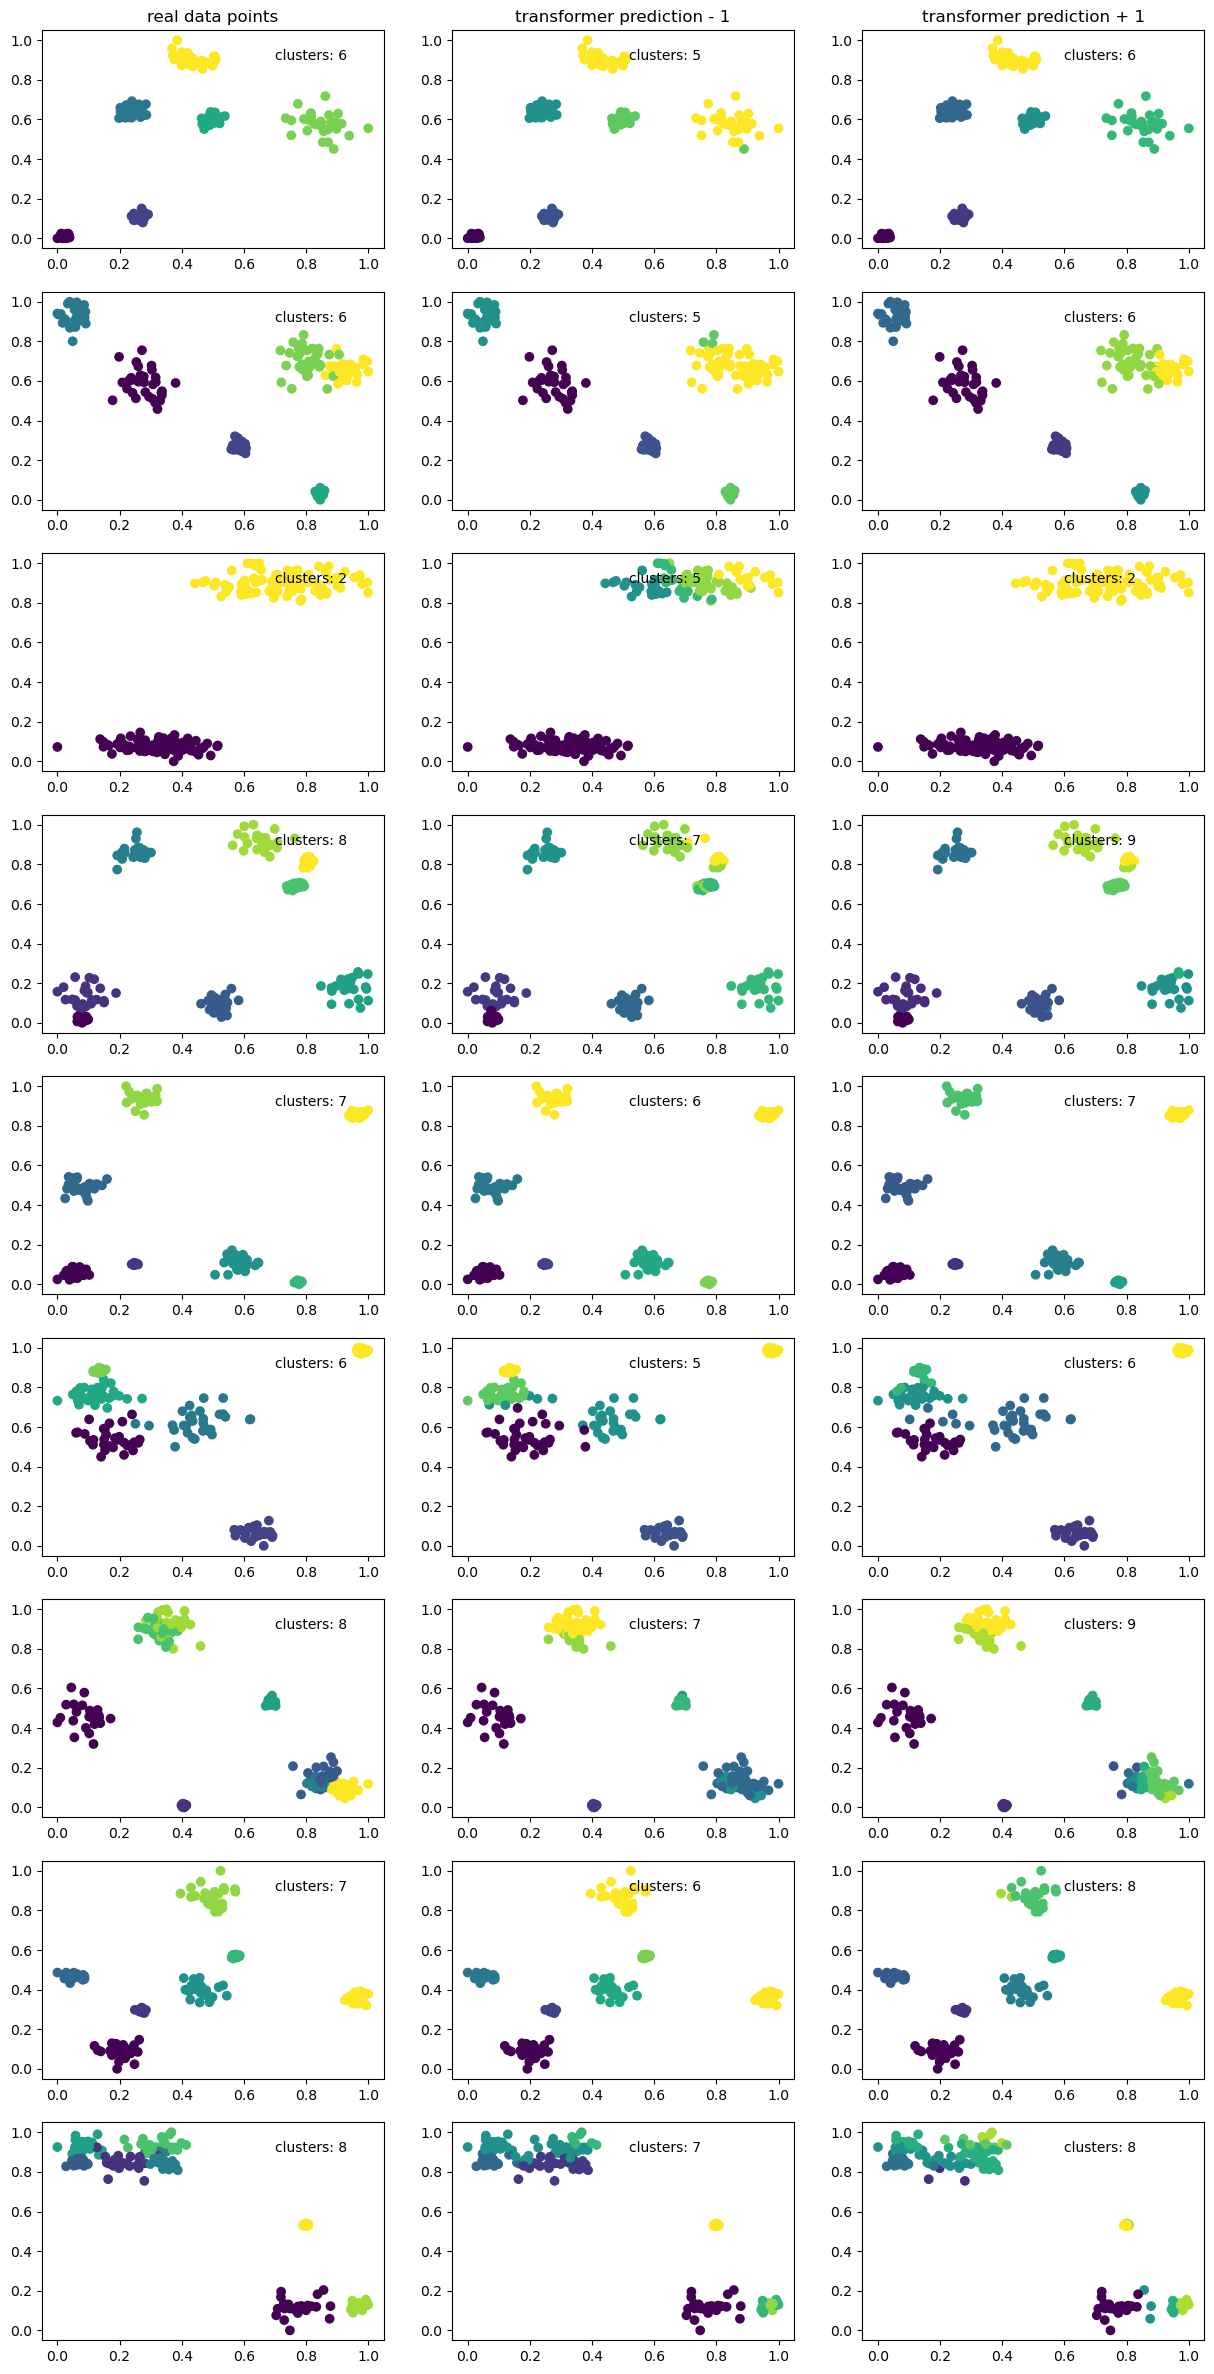

In [26]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    axes[3 * batch_index].text(0.7, 0.9, f"clusters: {torch.unique(train_y).numel()}") 
    batch = batch_classes[batch_index].unsqueeze(-1)
    #logits,cluster_output = model(train_x, batch)
    
    num1= torch.full(batch.shape, batch[0][0] - 1, dtype=torch.long, device=device)
    logits, cluster_output= model(train_x,num1)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    #axes[3 * batch_index + 1].text(0.6, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 
    axes[3 * batch_index + 2].text(-0.8, 0.9, f"clusters: {torch.unique(predictions).numel()}") 

    num2= torch.full(batch.shape, batch[0][0] + 1, dtype=torch.long, device=device)
    logits, cluster_output= model(train_x,num2)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[3 * batch_index +2].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    #axes[3 * batch_index + 2].text(0.6, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 
    axes[3 * batch_index + 2].text(0.6, 0.9, f"clusters: { torch.unique(predictions).numel() }") 

axes[1].set_title(f"transformer prediction - 1")
axes[0].set_title(f"real data points")
axes[2].set_title(f"transformer prediction + 1")
plt.show()